In [18]:
# libraries
import json
import lzma
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from IPython.core.display import display, HTML
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords  
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akirasato/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# defining a fucnction to remove \n and HTML tags
# function adapted from https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    text_divided = text.splitlines()
    text_divided_clean = " ".join(text_divided)
    text_divided_clean = text_divided_clean.lower()
    text_divided_clean = re.sub('"','', text_divided_clean) # remove '"'
    text_divided_clean = re.sub(r"'s\b","",text_divided_clean) # remove ''s'
    text_divided_clean = re.sub("[^a-zA-Z]", " ", text_divided_clean) # removes all strings that contains a non-letter
    tokens = [w for w in text_divided_clean.split() if not w in stop_words] 
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word (number of letters < 3)
            long_words.append(i)   
    return (" ".join(long_words)).strip()


# setting up tokenizer
tokenizer = RegexpTokenizer('\s+', gaps=True)

In [20]:
def get_data(state):
    # reading json files
    cases = []
    with lzma.open("../"+ state + '-text/data/data.jsonl.xz', 'r') as jsonl_file:
        for case in jsonl_file:
            cases.append(json.loads(str(case, 'utf-8')))

    df = pd.DataFrame(cases).sort_values('decision_date').reset_index(drop=True)
    df['decision_date'] = pd.to_datetime(df['decision_date'])

    # parsing data
    storage = []
    for i in range(df.shape[0]):
        casebody_idx = df.columns.get_loc("casebody")
        judges = df.iloc[i,casebody_idx]['data']['judges']
        attorneys = df.iloc[i,casebody_idx]['data']['attorneys']
        headnotes = df.iloc[i,casebody_idx]['data']['head_matter']
        if df.iloc[i,casebody_idx]['data']['opinions'] != []:
            opinions = df.iloc[i,casebody_idx]['data']['opinions'][0]['text']

        headnotes_clean = text_cleaner(headnotes)
        opinions_clean = text_cleaner(opinions)

        storage.append({'judges': judges,
                        'attorneys': attorneys,
                        'headnotes': headnotes_clean,
                        'opinions': opinions_clean})
    df_parsed = pd.DataFrame(storage)
    df = df_parsed.merge(df, left_index=True, right_index=True)

    # tokenizing headnotes and opinions
    df['headnotes'] = df['headnotes'].apply(lambda x: tokenizer.tokenize(x))
    df['opinions'] = df['opinions'].apply(lambda x: tokenizer.tokenize(x))
    df['headnotes_num_tokens'] = [len(notes) for notes in df['headnotes']]
    df['opinions_num_tokens'] = [len(opinions) for opinions in df['opinions']]

    return df

In [21]:
%%time

states = ['Arkansas', 'Illinois', 'New Mexico', 'North Carolina']

df_ar = get_data(states[0])
df_il = get_data(states[1])
df_nm = get_data(states[2])
df_nc = get_data(states[3])

dfs = [df_ar, df_il, df_nm, df_nc]

dfs = [df_ar]


ParserError: day is out of range for month: 1914-02-29

NameError: name 'dfs' is not defined

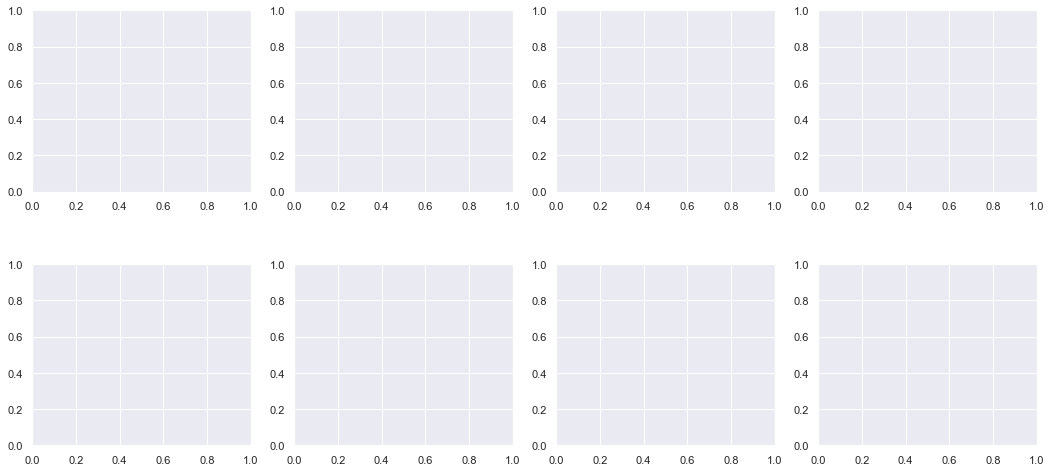

In [22]:
f, ax = plt.subplots(2,4, figsize=[18,8])
plt.subplots_adjust(hspace=0.4)
for c in range(len(states)):
    df = dfs[c]
    ax[0][c].plot(df.decision_date, df.headnotes_num_tokens, alpha=0.5)
    ax[0][c].set_title('Headnotes' + states[c], fontsize=20)
    ax[0][c].set_xlabel('Year of Decision', fontsize=16)
    ax[0][c].set_ylabel('Token Count', fontsize=16)

    ax[1][c].plot(df.decision_date, df.opinions_num_tokens)
    ax[1][c].set_title('Opinions' + states[c], fontsize=20)
    ax[1][c].set_xlabel('Year of Decision', fontsize=16)
    ax[1][c].set_ylabel('Token Count', fontsize=16)
    plt.show()